In [1]:
import numpy as np  # type: ignore
import onnx
import onnx.helper as h
import onnx.checker as checker
from onnx import TensorProto as tp
from onnx import save
import onnxruntime

# Builds a pipeline that resizes and crops an input. 
# Optionally, it takes the shape of the input as an input to the graph.
# This is to workaround an issue with the output of SequenceAt
def build_preprocessing_model(filename, has_shape_input=False):
    nodes = []

    if not has_shape_input:
        nodes.append(
            h.make_node('Shape', inputs=['x'], outputs=['x_shape'], name='x_shape')
        )

    nodes.append(
        h.make_node('Split', inputs=['x_shape'], outputs=['h', 'w', 'c'], axis=0, name='split_shape')
    )

    nodes.append(
        h.make_node('Min', inputs=['h', 'w'], outputs=['min_extent'], name='min_extent')
    )

    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['constant_256'], 
                    value=h.make_tensor(name='k256', data_type=tp.FLOAT, dims=[1], vals=[256.0]), 
                    name='constant_256')
    )

    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['constant_1'], 
                    value=h.make_tensor(name='k1', data_type=tp.FLOAT, dims=[1], vals=[1.0]),
                   name='constant_1')
    )

    nodes.append(
        h.make_node('Cast', inputs=['min_extent'], outputs=['min_extent_f'], to=tp.FLOAT, name='min_extent_f')
    )

    nodes.append(
        h.make_node('Div', inputs=['constant_256', 'min_extent_f'], outputs=['ratio-resize'], name='ratio-resize')
    )

    nodes.append(
        h.make_node('Concat', inputs=['ratio-resize', 'ratio-resize', 'constant_1'], outputs=['scales-resize'],
                    axis=0, name='scales-resize')
    )        

    nodes.append(
        h.make_node('Resize', inputs=['x', '', 'scales-resize'], outputs=['x_resized'], mode='linear', name='x_resize')
    )

    # Centered crop 224x224
    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['constant_224'], 
                    value=h.make_tensor(name='k224', data_type=tp.INT64, dims=[1], vals=[224]), name='constant_224')
    )

    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['constant_2'], 
                    value=h.make_tensor(name='k2', data_type=tp.INT64, dims=[1], vals=[2]), name='constant_2')
    )

    nodes.append(
        h.make_node('Shape', inputs=['x_resized'], outputs=['x_shape_2'], name='x_shape_2')
    )

    nodes.append(
        h.make_node('Split', inputs=['x_shape_2'], outputs=['h2', 'w2', 'c2'], name='split_shape_2')
    )

    nodes.append(
        h.make_node('Concat', inputs=['h2', 'w2'], outputs=['hw'], axis=0, name='concat_2')
    )   

    nodes.append(
        h.make_node('Sub', inputs=['hw', 'constant_224'], outputs=['hw_diff'], name='sub_224')
    )

    nodes.append(
        h.make_node('Div', inputs=['hw_diff', 'constant_2'], outputs=['start_xy'], name='div_2')
    )

    nodes.append(
        h.make_node('Add', inputs=['start_xy', 'constant_224'], outputs=['end_xy'], name='add_224')
    )

    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['axes'], 
                    value=h.make_tensor(name='axes_k', data_type=tp.INT64, dims=[2], vals=[0, 1]), name='axes_k')
    )

    nodes.append(
        h.make_node('Slice', inputs=['x_resized', 'start_xy', 'end_xy', 'axes'], outputs=['x_processed'], name='x_crop')
    )

    # Create the graph
    inputs = [h.make_tensor_value_info('x', tp.UINT8, [-1, -1, 3])]
    if has_shape_input:
        inputs += [h.make_tensor_value_info('x_shape', tp.INT64, [3])]
    
    g = h.make_graph(nodes, 'rn50-data-pipe-resize',
        inputs,
        [h.make_tensor_value_info('x_processed', tp.UINT8, [-1, -1, 3])]
    )

    # Make the preprocessing model
    op = onnx.OperatorSetIdProto()
    op.version = 14
    m = h.make_model(g, producer_name='onnx-preprocessing-resize-demo', opset_imports=[op])
    checker.check_model(m)

    # Save the model to a file
    save(m, filename)

build_preprocessing_model('preprocessing.onnx', has_shape_input=True)

Output sizes: 
(1280, 853)
(1280, 911)


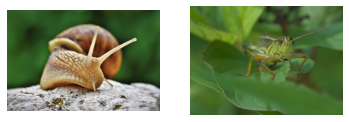

In [2]:
# display images in notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline

def show_images(images):
    nsamples = len(images)
    print("Output sizes: ")
    for i in range(nsamples):
        print(images[i].size)
    fig, axs = plt.subplots(1, nsamples)
    for i in range(nsamples):
        axs[i].axis('off')
        axs[i].imshow(images[i])
    plt.show()

images = [
    Image.open('../images/snail-4345504_1280.jpg'),
    Image.open('../images/grasshopper-4357903_1280.jpg')
]
show_images(images)

In [ ]:
session = onnxruntime.InferenceSession('preprocessing.onnx', None)

# Note: x_shape could be calculated from 'x' inside the graph, but we add it explicitly
# to workaround an issue with SequenceAt (https://github.com/microsoft/onnxruntime/issues/9868)
# To be removed when the issue is solved
out_images1 = []
for i in range(len(images)):
    img = np.array(images[i])
    result = session.run(
        [], 
        {
            'x': img,
            'x_shape': np.array(img.shape)
        }
    )
    out_images1.append(Image.fromarray(result[0]))

show_images(out_images1)

Output sizes: 
(224, 224)
(224, 224)


In [ ]:
import copy

preprocessing_model = onnx.load('preprocessing.onnx')
graph = preprocessing_model.graph

ninputs = len(graph.input)
noutputs = len(graph.output)

def tensor_shape(t):
    return [d.dim_value for d in t.type.tensor_type.shape.dim]

def tensor_dtype(t):
    return t.type.tensor_type.elem_type

def make_tensor_seq(t, prefix='seq_'):
    return h.make_tensor_sequence_value_info(prefix + t.name, tensor_dtype(t), tensor_shape(t))

def make_batch_tensor(t, prefix='batch_'):
    return h.make_tensor_value_info(prefix + t.name, tensor_dtype(t), [-1,] + tensor_shape(t))

cond_in = h.make_tensor_value_info('cond_in', onnx.TensorProto.BOOL, [])
cond_out = h.make_tensor_value_info('cond_out', onnx.TensorProto.BOOL, [])
iter_count = h.make_tensor_value_info('iter_count', onnx.TensorProto.INT64, [])

nodes = []
loop_body_inputs = [iter_count, cond_in]
loop_body_outputs = [cond_out]

for i in range(ninputs):
    in_name = graph.input[i].name
    nodes.append(
        onnx.helper.make_node(
            'SequenceAt',
            inputs=['seq_' + in_name, 'iter_count'],
            outputs=[in_name]
        )
    )

for n in graph.node:
    nodes.append(n)

for i in range(noutputs):
    out_i = graph.output[i]
    
    loop_body_inputs.append(
        make_tensor_seq(out_i, prefix='loop_seqin_')
    )
    loop_body_outputs.append(
        make_tensor_seq(out_i, prefix='loop_seqout_')
    )

    nodes.append(
        onnx.helper.make_node(
            'SequenceInsert',
            inputs=['loop_seqin_' + out_i.name, out_i.name],
            outputs=['loop_seqout_' + out_i.name]
        )
    )

nodes.append(
    onnx.helper.make_node(
        'Identity',
        inputs=['cond_in'],
        outputs=['cond_out']
    )
)
loop_body = onnx.helper.make_graph(
    nodes=nodes,
    name='loop_body',
    inputs=loop_body_inputs,
    outputs=loop_body_outputs,
)

In [ ]:
# Loop 
loop_graph_nodes = []

# Note: Sequence length is taken from the first input
loop_graph_nodes.append(
    onnx.helper.make_node(
        'SequenceLength', 
        inputs=['seq_' + graph.input[i].name], 
        outputs=['seq_len']
    )
)

loop_graph_nodes.append(
    onnx.helper.make_node(
        'Constant',
        inputs=[],
        outputs=['cond'],
        value=onnx.helper.make_tensor(
            name='const_bool_true',
            data_type=onnx.TensorProto.BOOL,
            dims=(),
            vals=[True]
        )
    )
)

loop_node_inputs = ['seq_len', 'cond']
loop_node_outputs = []
for i in range(noutputs):
    out_i = graph.output[i]
    loop_graph_nodes.append(
        onnx.helper.make_node(
            'SequenceEmpty',
            dtype=tensor_dtype(out_i),
            inputs=[], 
            outputs=['emptyseq_' + out_i.name]
        )
    )
    loop_node_inputs.append('emptyseq_' + out_i.name)
    loop_node_outputs.append('seq_out_' + out_i.name)
    
loop_graph_nodes.append(
    onnx.helper.make_node(
        'Loop',
        inputs=loop_node_inputs,
        outputs=loop_node_outputs,
        body=loop_body
    )
)

for i in range(noutputs):
    out_i = graph.output[i]
    loop_graph_nodes.append(
        onnx.helper.make_node(
            'ConcatFromSequence',
            inputs=['seq_out_' + out_i.name],
            outputs=['batch_' + out_i.name],
            new_axis=1,
            axis=0,
        )    
    )

# graph
graph = onnx.helper.make_graph(
    nodes=loop_graph_nodes,
    name='loop_graph',
    inputs=[make_tensor_seq(t) for t in graph.input],
    outputs=[make_batch_tensor(t) for t in graph.output],
)
op = onnx.OperatorSetIdProto()
op.version = 14

model = onnx.helper.make_model(graph, producer_name='loop-test', opset_imports=[op])
onnx.checker.check_model(model)
onnx.save(model, "loop-test.onnx")

In [ ]:
session = onnxruntime.InferenceSession("loop-test.onnx", None)
imgs = [np.array(image) for image in images]
img_shapes = [np.array(img.shape) for img in imgs]
result = session.run(
    [], 
    {
        'seq_x' : imgs,
        'seq_x_shape' : img_shapes,  # TODO: remove the shape input when SequenceAt issue is resolved
    }
)
print("Output shape: ", result[0].shape)
out_images2 = [Image.fromarray(result[0][i]) for i in range(2)]
show_images(out_images2)